# Description
This will focus on using classic regression models to model the data, instead of time series methods. 

#### NOTE: As described in EDA notebook, "Pseudo_ts" is concatenation of data from locally adjacent ski resorts (e.g., all resorts in Colorado) into a single timeseries.
# Imports

In [107]:
! pip install arviz pystan stan_utility
!pip install seaborn --upgrade

     |████████████████████████████████| 286kB 2.8MB/s 
  Found existing installation: seaborn 0.10.1
    Uninstalling seaborn-0.10.1:
      Successfully uninstalled seaborn-0.10.1


In [35]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    import os
    from google.colab import drive
    drive.mount('/content/gdrive')
    base_path = r'/content/gdrive/My Drive/data_sci/colab/ski/'
    os.chdir(base_path)
    try:
        ! git clone https://github.com/chrisoyer/ski-snow-modeling/
    except:  # if dir not empty e.g. already cloned
        pass
    mod_path = os.path.join(base_path, 
                            r"ski-snow-modeling/src/analysis/project_utils/project_utils.py")
    import importlib.util
    spec = importlib.util.spec_from_file_location(name="utils.name", location=mod_path)
    utils = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(utils)
    
    os.chdir('./ski-snow-modeling/')
    # Change the working directory to the repo root.
    # Add the repo root to the Python path.
    import sys
    sys.path.append(os.getcwd())
else:
    # local running
    import project_utils as utils

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
fatal: destination path 'ski-snow-modeling' already exists and is not an empty directory.


In [36]:
# data wrangling
import numpy as np
import pandas as pd
import os.path
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import pickle

# viz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import arviz as az

# modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
import pystan
import stan_utility

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters

In [37]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')
plt.rc('figure', figsize=(11.0, 7.0))

# Load Data

In [38]:
file_path = r'data/snow_data_clean.parquet'
all_data_path = os.path.join(os.getcwd(), file_path)

In [39]:
# parquet opening is broken on colab
with open(all_data_path, 'rb') as parq_file:
    long_series_df = pd.read_parquet(parq_file)
assert long_series_df.base.isna().sum()==0
month_ts_df = long_series_df.pipe(utils.resample_by_month, time_col='pseudo_ts')
# start analysis with just CO resorts
co_base_ts = (month_ts_df
              .query('state=="colorado"')
              .sort_values(by='pseudo_ts')
              .dropna(how='all')
             )
long_series_df.head()

,dayofyr,timestamp,base,station,snowfall,ski_yr,state,region,pseudo_ts_delt,pseudo_ski_yr,pseudo_ts,basecol_interpolated
11085,137.0,2016-01-10,0.000000,Mt. Holiday,2.0,5.0,michigan,Other,324.0,-31.0,1692-01-10,True
11086,138.0,2016-01-11,-2.320142,Mt. Holiday,3.0,5.0,michigan,Other,324.0,-31.0,1692-01-11,True
11087,139.0,2016-01-12,-2.320142,Mt. Holiday,5.0,5.0,michigan,Other,324.0,-31.0,1692-01-12,True
11088,140.0,2016-01-13,6.737995,Mt. Holiday,0.0,5.0,michigan,Other,324.0,-31.0,1692-01-13,False
11089,141.0,2016-01-14,10.000000,Mt. Holiday,0.0,5.0,michigan,Other,324.0,-31.0,1692-01-14,False


# Feature Engineering

In [40]:
def add_month(data: pd.DataFrame) -> pd.DataFrame:
    return data.assign(month=lambda x:
                       x.pseudo_ts.dt.month)

def add_diff(data: pd.DataFrame) -> pd.DataFrame:
    return (data
            .assign(delta_base=lambda x: x.base.diff(1))
            .fillna(0)
            .drop(columns=['base'])
           )

def ohe(data: pd.DataFrame, col: str) -> pd.DataFrame:
    return pd.concat([data.drop(columns=[col]),
                      pd.get_dummies(data[col],
                                     prefix=col)],
                     axis=1)

def add_month_x_snowfall(data: pd.DataFrame) -> pd.DataFrame:
    months = [col for col in data.columns
              if 'month_' in col]
    combos_df = pd.concat([pd.Series(data.snowfall * data[month],
                                     name='snowfall_x_' + month)
                           for month in months], axis=1)
    return pd.concat([data, combos_df], axis=1)

def cleaner(data: pd.DataFrame) -> pd.DataFrame:
    """ski_yr is needed for test/train split"""
    data = data.query('basecol_interpolated==True')
    bad_cols = ['dayofyr', 'station', 'state', 'pseudo_ski_yr',
                'timestamp', 'basecol_interpolated', 'pseudo_ts',
                'pseudo_ts_delt'
               ]
    return data.drop(columns=bad_cols)

In [41]:
data = (long_series_df.pipe(add_month)
        .pipe(add_diff)
        .pipe(ohe, 'month')
        .pipe(add_month_x_snowfall)
        .pipe(cleaner)
)
data.head()

,snowfall,ski_yr,region,delta_base,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,snowfall_x_month_1,snowfall_x_month_2,snowfall_x_month_3,snowfall_x_month_4,snowfall_x_month_5,snowfall_x_month_6,snowfall_x_month_7,snowfall_x_month_8,snowfall_x_month_9,snowfall_x_month_10,snowfall_x_month_11,snowfall_x_month_12
11085,2.0,5.0,Other,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11086,3.0,5.0,Other,-2.320142,1,0,0,0,0,0,0,0,0,0,0,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11087,5.0,5.0,Other,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31350,0.0,5.0,Other,-1.652098,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31351,0.0,5.0,Other,0.000001,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modeling

The evolution of snow base depth over time depends (not 1:1; a foot of powder is only a few inches of packed powder) on new snowfall and melting of old snow. I will start by modeling as a simple timeseries, and then include new snowfall as a predictor variable.

## Modeling Setup
I will use regular cross validation.

In [42]:
def split_xy(df: pd.DataFrame) -> (np.array, np.array):
    """splits data into X and y arrays
    drops columns used in train_test_split before this func"""
    df = df.drop(columns=['ski_yr', 'region'])
    return (df.drop(columns=['delta_base']).to_numpy(),
            df.delta_base.to_numpy().reshape(-1))


def train_test_split(data: pd.DataFrame) -> (np.array, np.array, np.array, np.array):
    """splits data
    Output: (X_train, y_train, X_test, y_test)
    """
    train, test = data.query("ski_yr!=8"), data.query("ski_yr==8")
    return (*split_xy(train), *split_xy(test))

## ElasticNet Linear Regression Model - Fixed Effects model
This is a fixed effects model WRT region, considering the melting effects pooled by month.

In [43]:
def get_results(data: pd.DataFrame, region: str, 
                include_resids: bool=False) -> pd.DataFrame:
    """splits data, trains model for region, and puts results into dataframe
    Arguments:
        data: dataframe with X & y
        region: region to look at
        include_resids: if all y & ŷ instances should be returned inside the dataframe
            WARNING: increases size of df greatly
    Returns: dataframe """
    X_train, y_train, X_test, y_test = train_test_split(data)
    lin_regr = ElasticNetCV(cv=5)
    
    lin_regr.fit(X_train, y_train)
    y_hat_test = lin_regr.predict(X_test)
    lin_resid = y_test - y_hat_test
    results = {}
    results['r2'] = lin_regr.score(X_test, y_test)
    lin_regr_resids = pd.DataFrame(lin_resid)
    results['mse'] = (lin_regr_resids**2).sum()[0]
    results['mae'] = lin_regr_resids.sum().abs()[0]
    results_df = pd.DataFrame(results, index=[region])
    col_list = [c for c in data.columns 
                if c not in ['ski_yr', 'region', 'delta_base']]
    coefs_df = pd.DataFrame(data=lin_regr.coef_.reshape(1,-1), 
                            columns=col_list, index=[region])
    results_df = pd.concat([results_df, coefs_df], axis=1)
    if include_resids:
        results_df['y'] = pd.Series(data=None, dtype='object', name='y')
        results_df['y_hat'] = pd.Series(data=None, dtype='object', name='y_hat')
        results_df.at[region, 'y_hat'] = [y_hat_test]
        results_df.at[region, 'y'] = [y_test]
    return results_df

In [44]:
colo = (get_results(data[data.region=="Colorado"], 'Colorado'))

In [45]:
regional_regression = pd.concat([get_results(data.query("region==@region"), 
                                             region, include_resids=True)
                                 for region in data.region.unique()])

In [46]:
result = regional_regression.drop(columns=['y', 'y_hat']).mean().to_frame().T
result

,r2,mse,mae,snowfall,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,snowfall_x_month_1,snowfall_x_month_2,snowfall_x_month_3,snowfall_x_month_4,snowfall_x_month_5,snowfall_x_month_6,snowfall_x_month_7,snowfall_x_month_8,snowfall_x_month_9,snowfall_x_month_10,snowfall_x_month_11,snowfall_x_month_12
0,0.115945,17167.100144,157.711893,0.003193,0.115638,0.076826,-0.026375,-0.102577,-0.432486,-0.67448,-0.34804,0.065516,0.388345,0.499684,0.125544,-0.100142,-0.056653,0.012345,0.011031,-0.03356,-0.010063,0.0,0.0,0.0,0.0,0.0,0.000276,0.011492


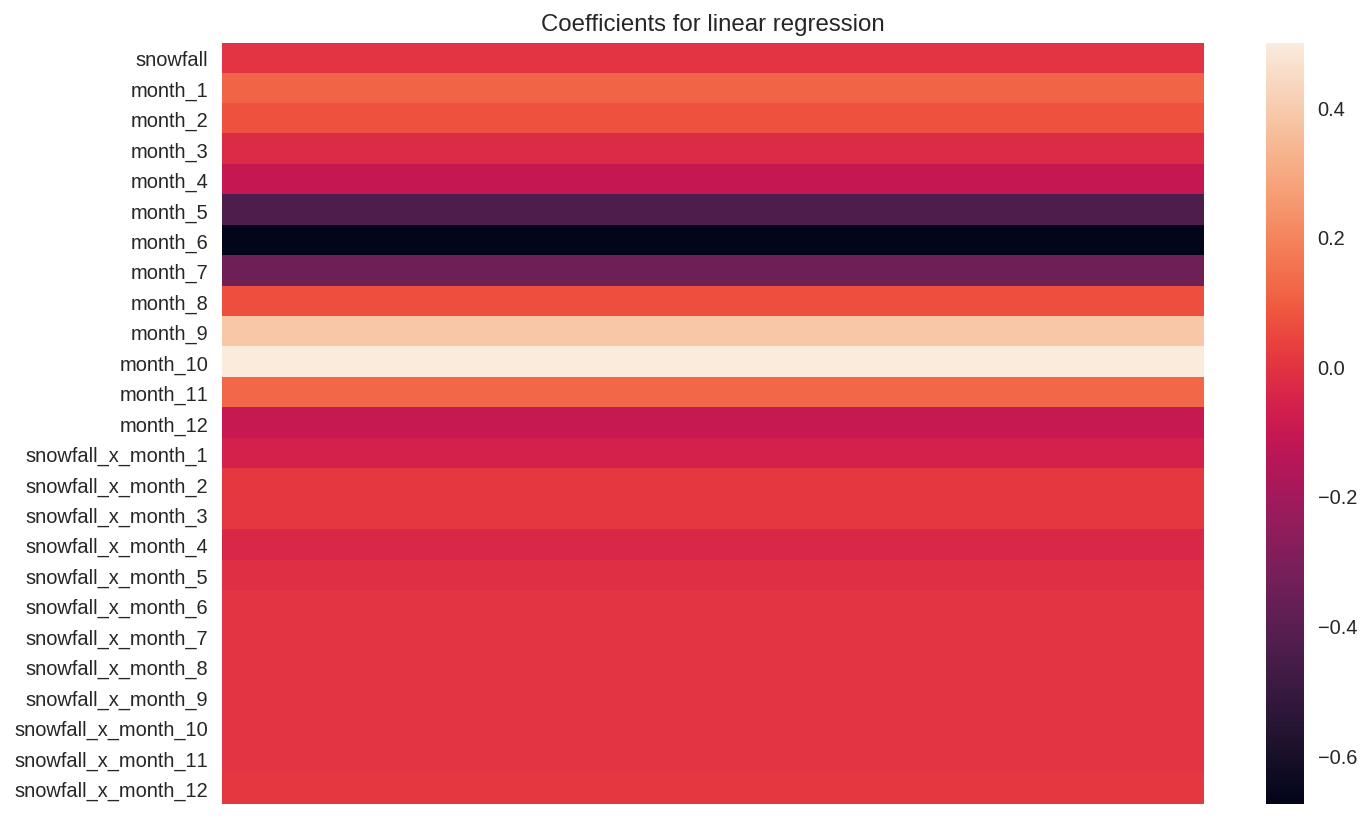

In [47]:
fig, ax = plt.figure(), plt.axes()
sns.heatmap(data=result.drop(columns=['mse', 'mae', 'r2']).T, ax=ax)
plt.title("Coefficients for linear regression")
ax.set_xticklabels("")
plt.show();

We do see lower values for the month labels during summer, but some months seem to "grow" snow without actual snowfall!

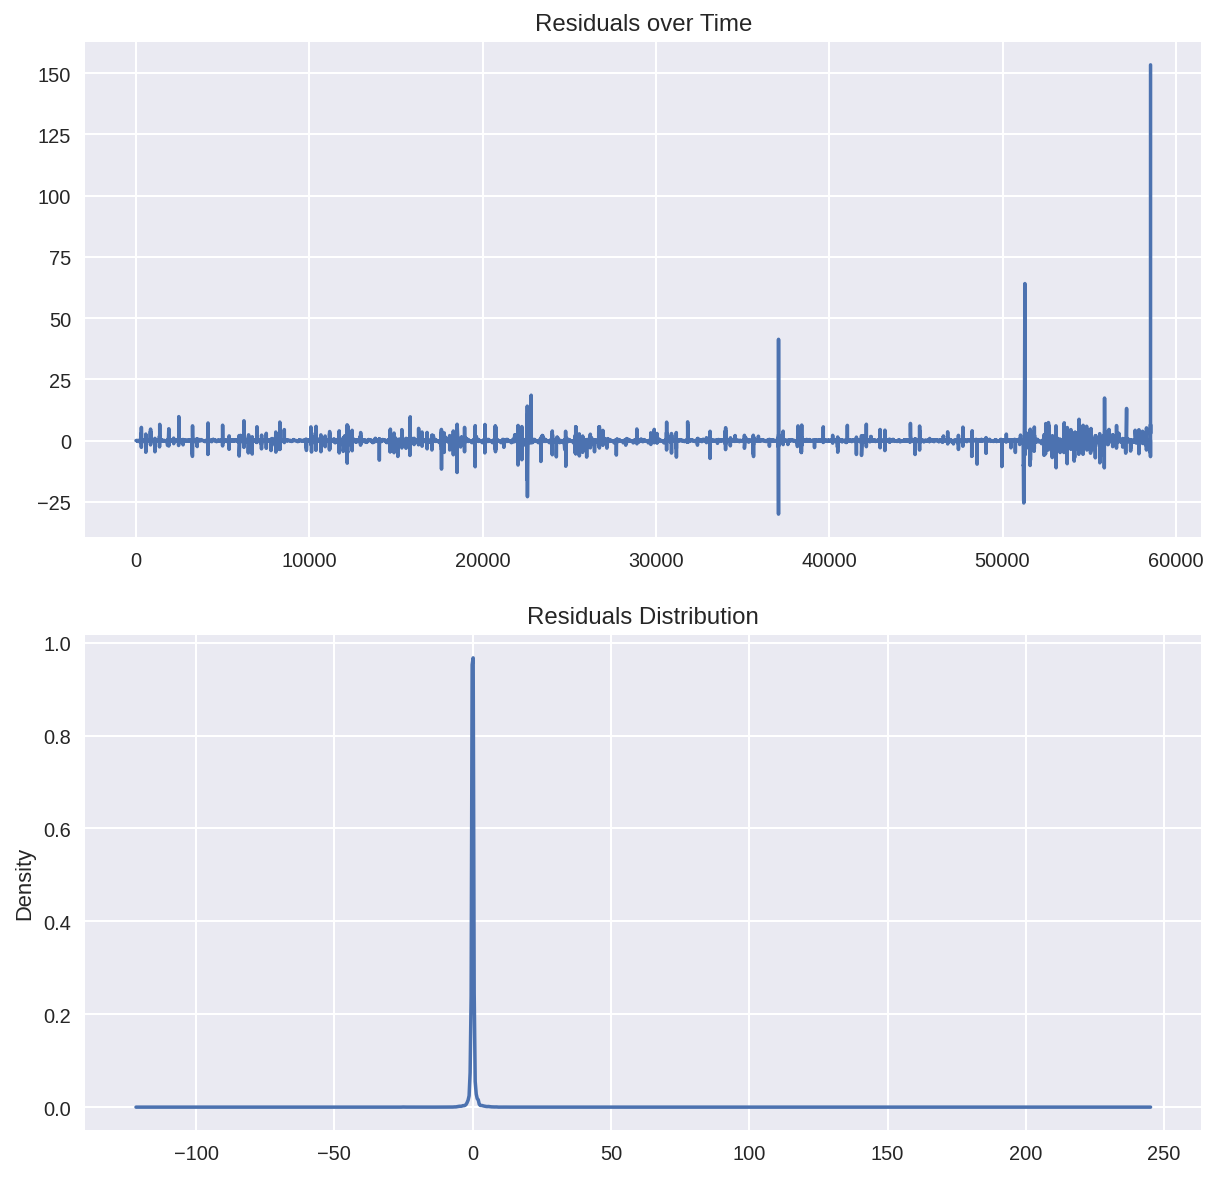

count    58542.000000
mean        -0.008443
std          1.531640
min        -30.035679
25%         -0.165369
50%         -0.015371
75%          0.162994
max        153.372815
dtype: float64


In [48]:
lin_regr_resids = pd.DataFrame()
lin_regr_resids['y']= np.concatenate([y[0] for y in regional_regression.y])
lin_regr_resids['y_hat'] = np.concatenate([yh[0] for yh in regional_regression.y_hat])
utils.resid_plotter(residuals=lin_regr_resids.y_hat-lin_regr_resids.y,
                    y=lin_regr_resids.y)

The betas on the snow and monthly evolution (e.g. melting) are all over the place. I will turn to a baysian model to constrain these.

# Bayesian Model in Stan (MCMC)
I want to add priors to the model that snowfall should only result in increases in base depth, and monthly effects should only result in reduction (i.e., monthly effect should measure strength of melting.); changes at odds with this should be considered as noise. A bayesian model allows for this.

In [49]:
stan_df = (long_series_df
           .pipe(add_month)
           .pipe(add_diff)
           .pipe(ohe, 'region')
           .pipe(ohe, 'month')
           .pipe(cleaner)
            )
stan_df.head()

,snowfall,ski_yr,delta_base,region_Cascades,region_Colorado,region_East,region_New_England,region_Other,region_Rockies_Other,region_Sierras,region_Utah,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
11085,2.0,5.0,0.000000,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
11086,3.0,5.0,-2.320142,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
11087,5.0,5.0,0.000000,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
31350,0.0,5.0,-1.652098,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
31351,0.0,5.0,0.000001,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [103]:
# sample data; half million records => slow mcmc
stan_sample_df = (stan_df
                  .query('interpolated_basecol==0')
                  .sample(frac=.2, axis=0, replace=False))

# provide data including shapes and column type locations to stan
columns = stan_df.columns
region_cols = [c for c in columns if "region" in c]
month_cols = [col for col in stan_sample_df.columns if "month" in col]

X = stan_sample_df.drop(columns=['delta_base', 'ski_yr'])
X_month= X[month_cols]
X_snow = X['snowfall']
X_region = X[region_cols]
y = stan_sample_df[['delta_base']]
stan_data = {'N': X.shape[0],
             'K_month': X_month.shape[1],
             'X_month': X_month.to_numpy(),
             'K_reg': X_region.shape[1],
             'X_reg': X_region.to_numpy(),
             'X_snow': X_snow.to_numpy().reshape(-1,1),
             'y': y.to_numpy().reshape(-1),
             }

UndefinedVariableError: ignored

In [53]:
stan_model_str = """
data {
    // input data passed from Python
    int<lower=1> N;               // number of data observations
    int<lower=1> K_month;         // no of melting predictor
    matrix[N, K_month] X_month;   // predictor for melting features
    int<lower=1> K_reg;           // no of region features
    matrix[N, K_reg] X_reg;       // region predictors
    matrix[N, 1] X_snow;          // snowfall predictor
    vector[N] y;                  // response vector

}
transformed data {
    matrix[N, K_reg] X_reg_snow;
    row_vector[N] X_snow_rvect = to_row_vector(X_snow);
    for (k in 1:K_reg) {          //  K_regxN * Nx1  T
        for (n in 1:N) {
            X_reg_snow[n,k] = X_snow_rvect[n] * X_reg[n,k];
    }  }
}
parameters {
    // intercept was causing divergences and coef interpretation 
    // makes more sense without intercept: 
    // I don't expect change in base depth absent melting or snowfall
    vector<upper=0>[K_month] beta_mo;  // coefficients for melting
    vector<lower=0>[1] beta_snow;      // coefficients for snowfall
    vector[K_reg] beta_reg;            // coef for region OHE
    vector<lower=-1, upper=1>[K_reg] beta_reg_snow;       // coef for region x snow interaction
    real<lower=0> sigma;               // must be +ve
    real<lower=0> sig_mos;             // must be +ve
}
transformed parameters {}
model {
    vector[N] mu;                       // y_hat
    sigma ~ cauchy(0, 10);              // half Cauchy
    sig_mos ~ cauchy(0, 20);
    for (n in 1:K_month) {
        beta_mo[n] ~ normal(0, sig_mos) T[,0]; // sample from normal, only -ve
    }
    beta_snow[1] ~ beta(2.2, 3);                // prior on snow columns is beta over [0,1]
    beta_reg_snow ~ uniform(-1,1);      // reparameterize so this and snow are from beta dist
    mu = X_month*beta_mo + X_snow*beta_snow + X_reg*beta_reg + X_reg_snow*beta_reg_snow;
    y ~ normal(mu, sigma);
}
"""

In [54]:
sm = pystan.StanModel(model_code=stan_model_str, model_name='stan_model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL stan_model_42cbc9200cbed8e100c25752c2abfe18 NOW.


In [55]:
# avoid recompile if possible
with open('./models/stan_model.pkl', 'wb') as f:
    pickle.dump(sm, f)

In [56]:
fit = sm.sampling(data=stan_data, iter=2_000, chains=4, n_jobs=-1,
                  control={'adapt_delta': 0.9, # p accepting posterior draw
                           'stepsize': .01,}, 
                  seed=42, verbose=True)

In [57]:
fit

Inference for Stan model: stan_model_42cbc9200cbed8e100c25752c2abfe18.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
beta_mo[1]     -0.02  2.9e-4   0.02   -0.08   -0.03   -0.02 -7.4e-3 -6.4e-4   5274    1.0
beta_mo[2]     -0.01  1.6e-4   0.01   -0.04   -0.02 -8.7e-3 -3.8e-3 -3.9e-4   5589    1.0
beta_mo[3]     -0.07  5.5e-4   0.03   -0.13   -0.09   -0.06   -0.04 -8.6e-3   3294    1.0
beta_mo[4]     -0.22  2.7e-4   0.02   -0.26   -0.23   -0.22   -0.21   -0.18   4941    1.0
beta_mo[5]     -0.51  2.3e-4   0.02   -0.54   -0.52   -0.51    -0.5   -0.47   5948    1.0
beta_mo[6]     -0.71  2.3e-4   0.02   -0.74   -0.72   -0.71    -0.7   -0.68   5615    1.0
beta_mo[7]     -0.39  2.3e-4   0.02   -0.42    -0.4   -0.39   -0.37   -0.35   5593    1.0
beta_mo[8]     -0.01  1.7e-4   0.01   -0.04   -0.02   -0.01 -5.2e-3 -3.9e-4   3752    1.0
b

In [58]:
# for overnight run
result_path = './models/stan_results.pkl'
try:
    fit
except NameError:
    with open(result_path, 'rb') as f:
        pickle.load(fit, f)
else:
    with open(result_path, 'wb') as f:
        pickle.dump(fit, f)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  # Remove the CWD from sys.path while we load stuff.


## MCMC Diagnostics
We will want to check:
1. Model actually runs.
1. Good Mixing of Chains: (fix with stronger prior, reparameterization)
    1. $\hat{R}$ is 1.1 or under for all parameters.
    1. When n_eff / n_transitions < 0.001 the estimators that we use are often biased and can significantly overestimate the true effective sample size.
1. Check tree depth:
if threshold saturated, increase tree depth _control={max_treedepth: 15}_
1. 

_



In [59]:
stan_utility.check_all_diagnostics(fit)

n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


,chain,draw,warmup,beta_mo[1],beta_mo[2],beta_mo[3],beta_mo[4],beta_mo[5],beta_mo[6],beta_mo[7],beta_mo[8],beta_mo[9],beta_mo[10],beta_mo[11],beta_mo[12],beta_snow[1],sigma,sig_mos,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,1.5,499.5,0.0,-0.023586,-0.012118,-0.065334,-0.220306,-0.508878,-0.708242,-0.385689,-0.013616,-0.000851,-0.000662,-0.004626,-0.098632,0.017483,1.28405,0.31925,-35822.338827,0.941126,0.295386,3.7455,13.872,0.0,35829.775679


In [95]:
# fix brackets in col nmaes
fit_df = (fit.to_dataframe()
          .rename(columns=lambda x: x.replace("[", "_"))
          .rename(columns=lambda x: x.replace("]", "")))

fit_df.head()


,chain,draw,warmup,beta_mo_1,beta_mo_2,beta_mo_3,beta_mo_4,beta_mo_5,beta_mo_6,beta_mo_7,beta_mo_8,beta_mo_9,beta_mo_10,beta_mo_11,beta_mo_12,beta_snow_1,sigma,sig_mos,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,-0.022833,-0.003314,-0.047679,-0.232006,-0.516763,-0.679852,-0.362417,-0.019516,-0.000447,-0.000293,-0.001086,-0.085178,0.015002,1.285314,0.328770,-35819.505881,0.967208,0.335458,4,15,0,35827.966761
1,0,1,0,-0.001178,-0.017474,-0.075068,-0.226951,-0.511388,-0.703169,-0.356331,-0.008056,-0.000629,-0.000176,-0.002723,-0.150737,0.027264,1.283339,0.416476,-35821.618846,0.838400,0.335458,3,7,0,35828.281450
2,0,2,0,-0.000863,-0.002837,-0.080294,-0.243397,-0.487397,-0.712705,-0.422903,-0.001757,-0.000402,-0.000963,-0.001906,-0.049234,0.015333,1.284175,0.329193,-35825.806210,0.913564,0.335458,4,15,0,35830.208140
3,0,3,0,-0.116516,-0.012047,-0.058045,-0.210824,-0.521146,-0.714253,-0.352122,-0.028103,-0.000573,-0.000282,-0.001617,-0.113752,0.013903,1.283911,0.303902,-35821.127226,0.992303,0.335458,4,15,0,35829.795988
4,0,4,0,-0.022586,-0.012467,-0.100567,-0.217720,-0.526921,-0.710090,-0.339664,-0.009445,-0.000811,-0.001952,-0.003015,-0.141406,0.025635,1.286184,0.241495,-35821.452333,0.997607,0.335458,3,7,0,35830.585114


## Visualization of results

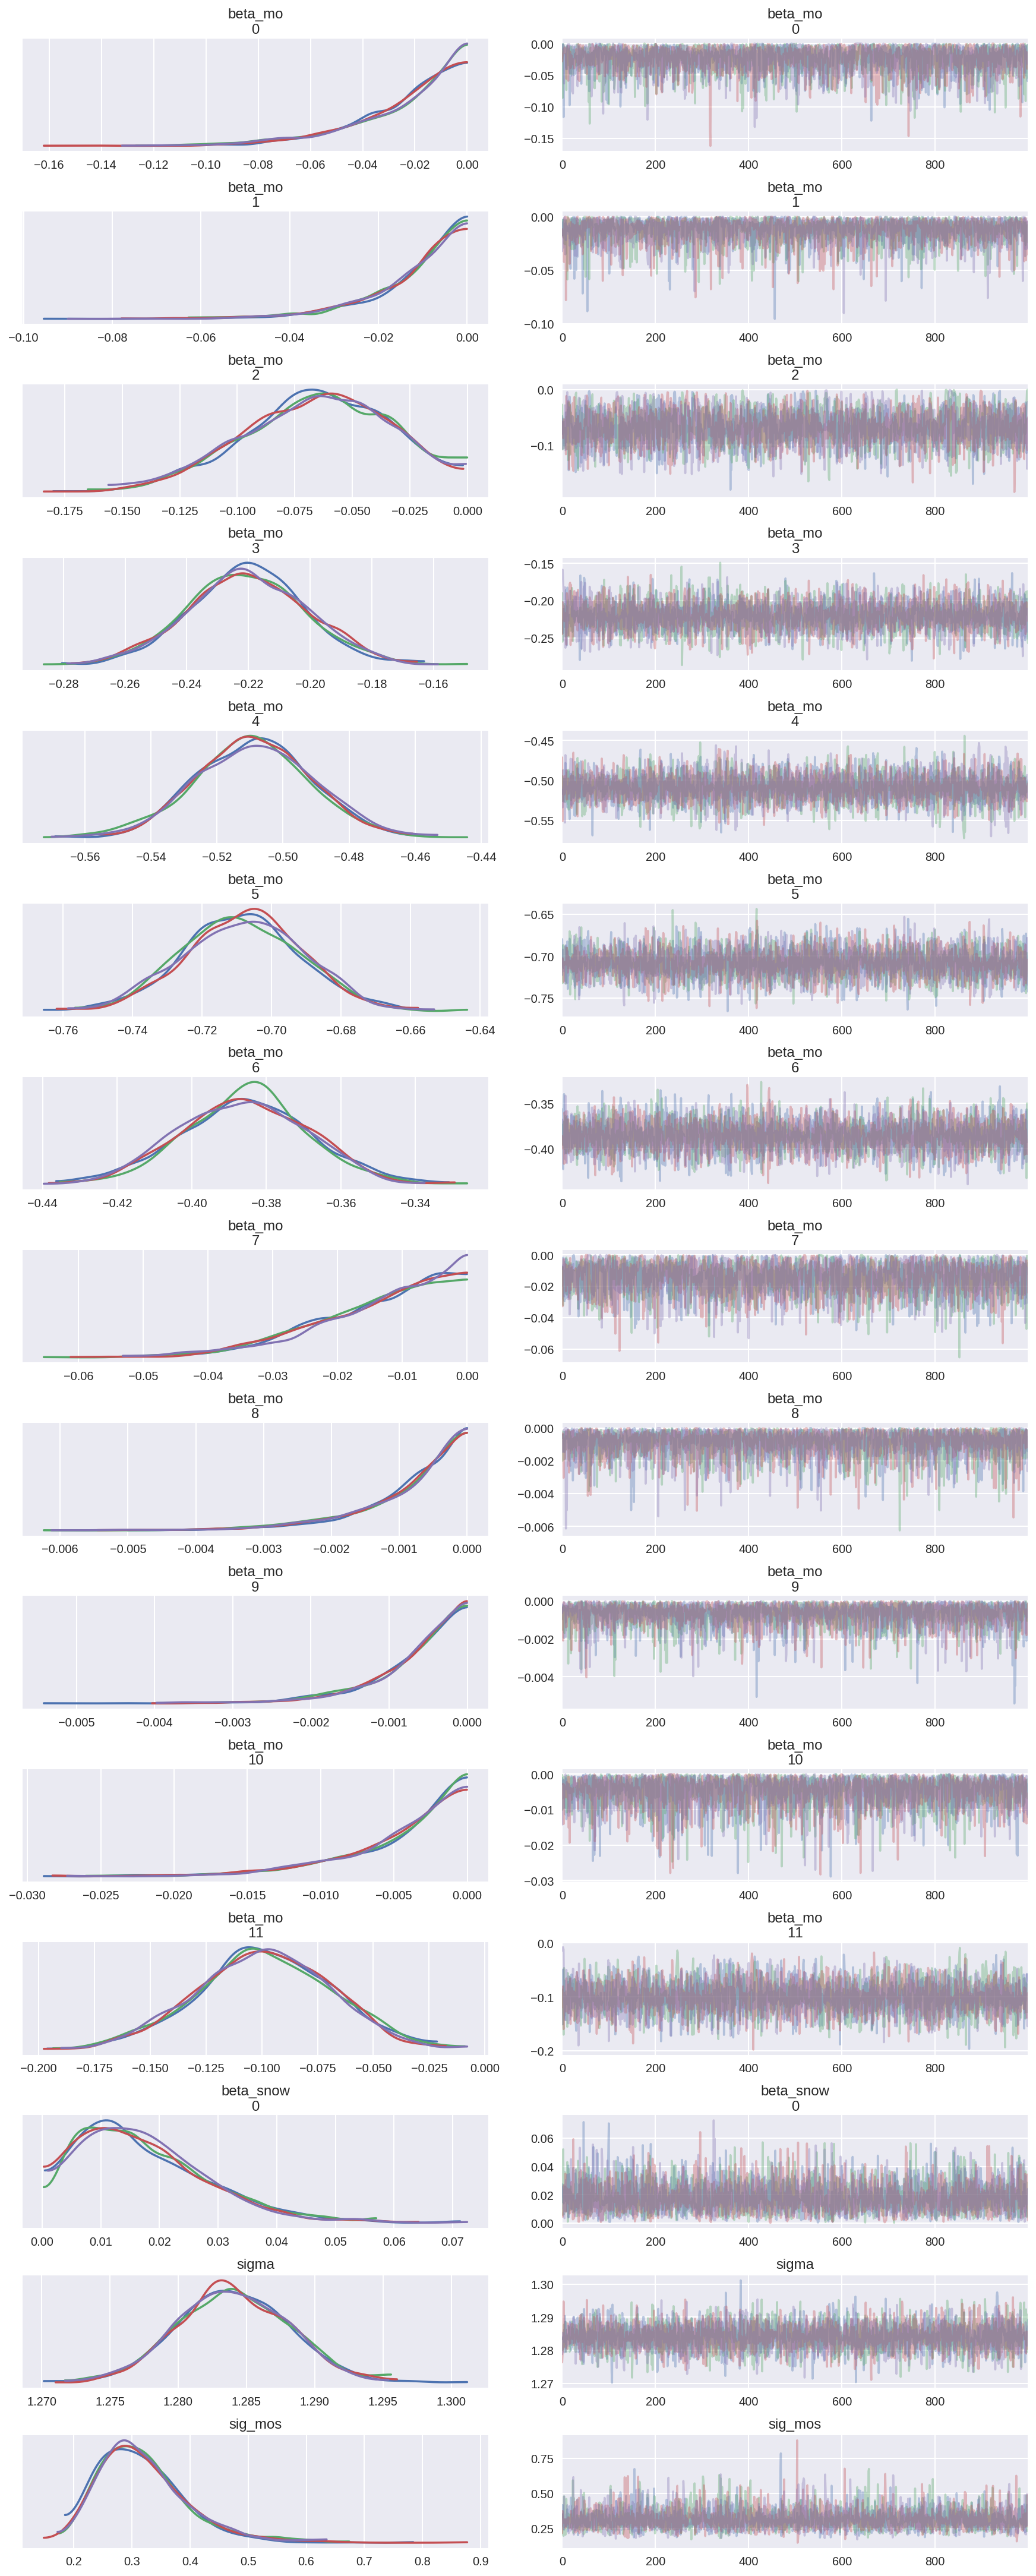

In [60]:
az.plot_trace(fit);

These estimates are mostly expected, but there seems to be low melting amounts during summer...this can be explained when we realize that most of the values for May-November were interpolated. The averages aren't weighted by ski acreage, so the large number of small ski stations on the east coast & midwest with short seasons are disproportionately affecting these numbers. 

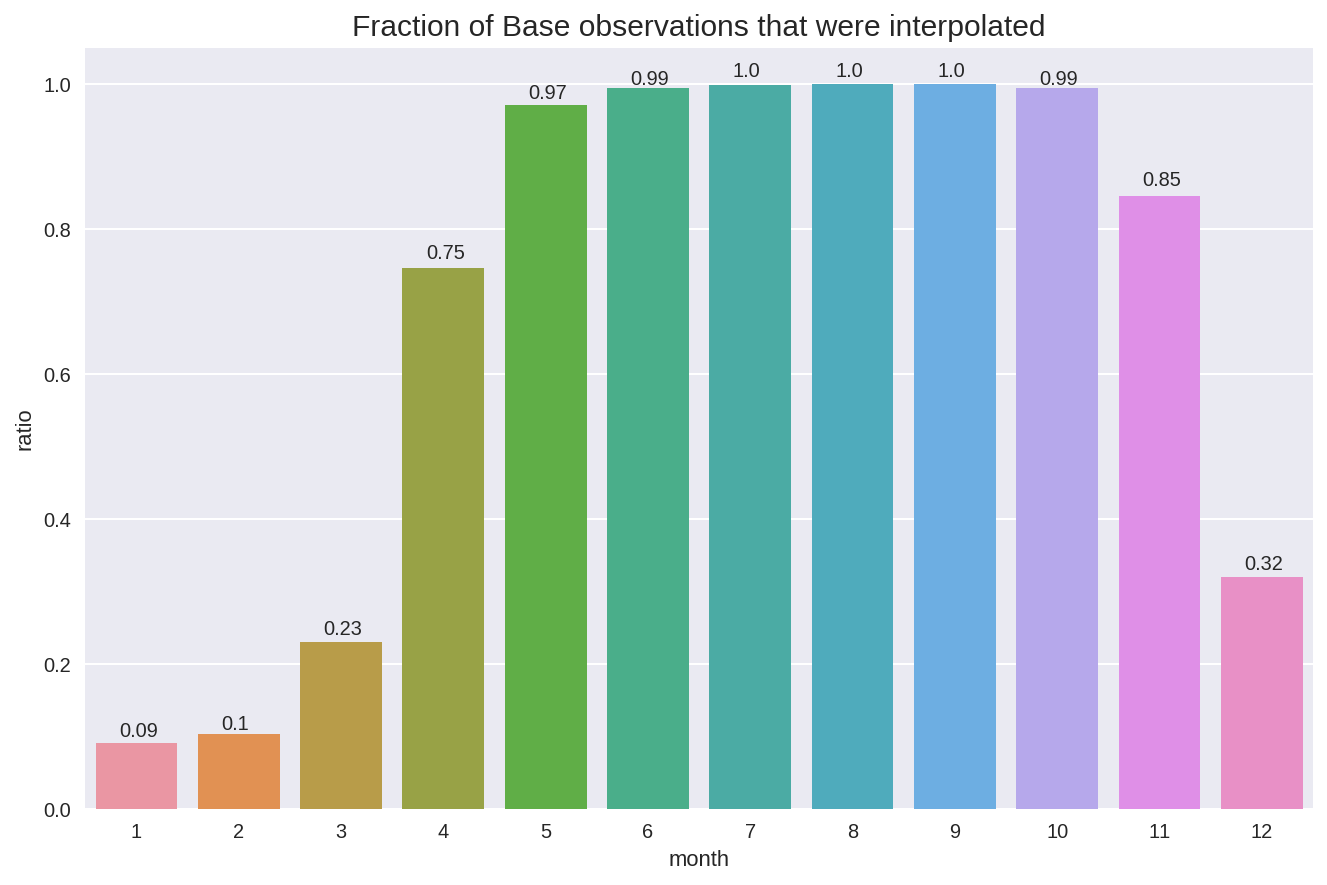

In [90]:
interpo_ratios=(long_series_df
    .assign(month=lambda x: x.pseudo_ts.dt.month)
    .groupby('month')
    .apply(lambda x: x.basecol_interpolated.sum()/x.shape[0])
    .to_frame()
    .reset_index()
    .rename(columns={0:'ratio'})
)
sns.barplot(data=interpo_ratios, x='month', y='ratio')
plt.title('Fraction of Base observations that were interpolated', fontsize=15)
[plt.text((i-.17), value+.01, str(value)) for i, value in enumerate(interpo_ratios.ratio.round(2).to_numpy())];